<a href="https://colab.research.google.com/github/MaidinuerSaimi/Python-courses/blob/main/Deep%20Learning%20models%20for%20image%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Before we start --- How to use this notebook

This is a Google colab notebook with a `Python` backend.  No knowledge of notebooks or `Python` is necessary.  The following will get you going:
* The notebook is divided into cells.  There are text cells (such as this one), and code cells (with a `grey` background)
* Click inside a `code` cell and press "Shift-Enter" to execute code.  The code runs in the cloud; output will be rendered below the cell.
* Code can be edited, and re-run as often as you like.  
* Add cells by pointing between existing cells and clicking `+ Code`
* Variables once defined can be used in any cell (below it, or above it)
* If you like you can double click a text cell to edit it; press "Shift-Enter" to render. We're not using that today.

Edits that you make will be visible to you, but not to others.  You can save your own copy of the notebook if you like.  If things stop working, just close the notebook, open a fresh unchanged copy, and start again.

# Part 1: Introduction to Deep Learning models for image analysis

This tutorial will show you how to build and train a Deep Learning model for image analysis.

In parts 1 and 2 we will use the famous `MNIST` dataset, a set of `70000` grayscale low-resolution images of handwritten digits.  This dataset was created in 1998 and has been used as a benchmark for image classification methods for many years.  The initial paper achieved a `0.8%` error rate - can we do better?

In [ ]:
## import the packages that we'll use:
## tensorflow - the workhorse of deep learning - fast calculation on GPUs, automatic gradient calculation, ...
## numpy      - calculating with matrices, arrays, tensors, ...
## matplotlib - for making plots
## keras      - high-level API for building deep learning models; uses Tensorflow underneath

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

print('Tensorflow version: {}'.format(tf.__version__))   ## this should show 2.19.0 or later

device_name = tf.test.gpu_device_name()
print('Found device: {}'.format(device_name))   ## tell whether notebook uses CPU or GPU (both work, GPU is faster)

## If you don't see something like "/device:GPU:0" below, click on "Runtime", "Change runtime type" and select
## GPU under "Hardware acceleration"

Tensorflow version: 2.19.0
Found device: /device:GPU:0


In [ ]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data("mnist.npz")
x_train = x_train / 255.0
x_test = x_test / 255.0
print("Loaded ", len(x_train)," training examples and ",len(x_test)," test examples")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded  60000  training examples and  10000  test examples


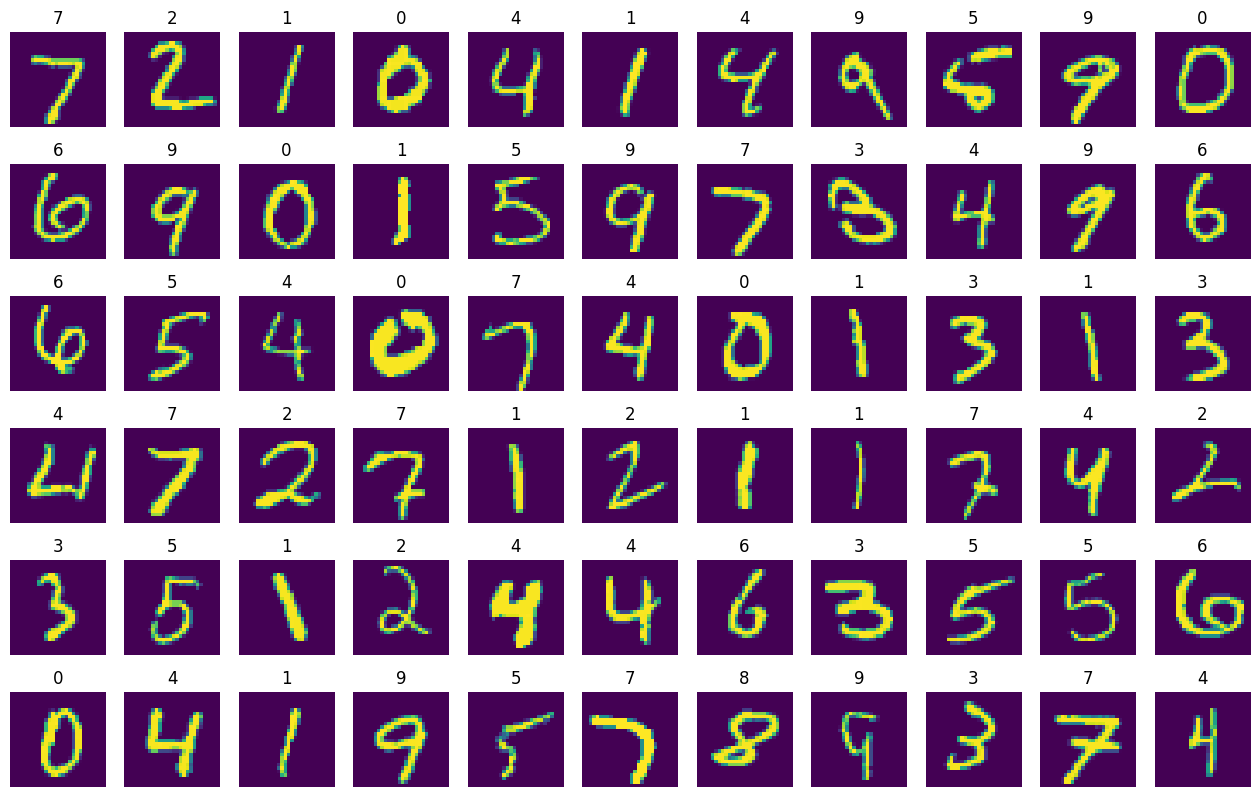

In [ ]:
def plot_data( data=None, labels=None, gridx=11, gridy=6, generator=None ):
    fig, axs = plt.subplots(gridy, gridx, figsize=(16, 10))  ## set overall size of figure, and layout of subfigures
    axs = np.reshape(axs, -1)
    if generator is None:
        gen = zip(data, labels)
    else:
        def loop_over_batch(gen):
            for ims, labs in gen:
                for im, lab in zip(ims, labs):
                    label = "chest" if lab == 0.0 else "abdominal"   ## for tutorial Part 3
                    yield im, label
        gen = loop_over_batch(generator)
    for image_num, (image, label) in enumerate(gen):
        if image_num >= gridx * gridy:
            break
        axs[image_num].imshow( image )
        axs[image_num].set_title(str(label))
        axs[image_num].axis("off")

## Plots the first 16*10 images (x_i) and labels (y_i)
plot_data( x_test, y_test )

In [ ]:
batch_size = 32      ## number of images processed in one go (mostly for speed, but affects training too)
epochs = 20          ## number of times the entire training set is processed during the training phase

# here we set up the actual model.
#
# The Sequential model (a sort of pipeline) allows you to provide a list of layers that will be connected sequentially.
# Layer 1: takes an input image (28x28 2-dimensional array) and "flattens" it to a linear (1-dimensional) array of length 784
# Layer 2: 512-node dense layer (connect all 784 imputs to each of the 512 outputs with separate weights), followed by a ReLU activation
# Layer 3: dropout layer; this randomly switches off a fraction of nodes (here: 20%), which reduces overfitting - acts as a regularizer
# Layer 4: final dense layer with 10 outputs; softmax ensures output may be interpreted as probabilities
model1 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(name="First_layer"), #,input_shape=(28,28)),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax)])

# choose the optimizer, and set some of its parameters.  Adam is a good all-round choice
# (you can think of Adam as gradient descent with adaptive step size, and memory for promising directions)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Tie everything together
# Here we select the loss function that will define the target for optimization
# This is a classification model, so we use categorical crossentropy (the -log likelihood of a discrete distribution)
# Since the target is a label (0-9), while the model output are probabilities, use the "sparse" version;
# the standard (non-sparse) version expects 10 one-hot encoded variables as target
model1.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# print a tabular summary of the model we just constructed. Note how many parameters we have!
# A far cry from a standard logistic regression.
print(model1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ First_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Now, fit the model's parameter so as to minimize the loss on the training data
# At the end of each full sweep over the training data (which is called an epoch), show the loss and
# accuracy on the validation data (that otherwise isn't used for training)
# Do this 20 times. This takes about 2 minutes.
# You will see the loss decrease, training accuracy increase. Keep an eye on the validation accuracy
#
# (While you watch the model train, think about it: there are half a million parameters and 60,000 images,
# each containing over 750 numbers. Training involves calculating a prediction, a loss, and then partial
# derivatives of the loss function with respect to all half-a-million parameters. Yes, training is
# INCREDIBLY fast. All because of GPUs - graphic cards that were originally developed for playing games.
history = model1.fit(
            x = x_train,
            y = y_train,
            batch_size = batch_size,
            steps_per_epoch = len(x_train) // batch_size,
            epochs = epochs,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // batch_size)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8939 - loss: 0.3507 - val_accuracy: 0.9705 - val_loss: 0.0925
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9709 - loss: 0.0920 - val_accuracy: 0.9705 - val_loss: 0.0974
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9811 - loss: 0.0632 - val_accuracy: 0.9750 - val_loss: 0.0776
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9847 - loss: 0.0485 - val_accuracy: 0.9809 - val_loss: 0.0652
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9888 - loss: 0.0354 - val_accuracy: 0.9813 - val_loss: 0.0733
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9903 - loss: 0.0305 - val_accuracy: 0.9786 - val_loss: 0.0831
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9786 - val_loss: 0.0916
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9926 - loss: 0.0235 -

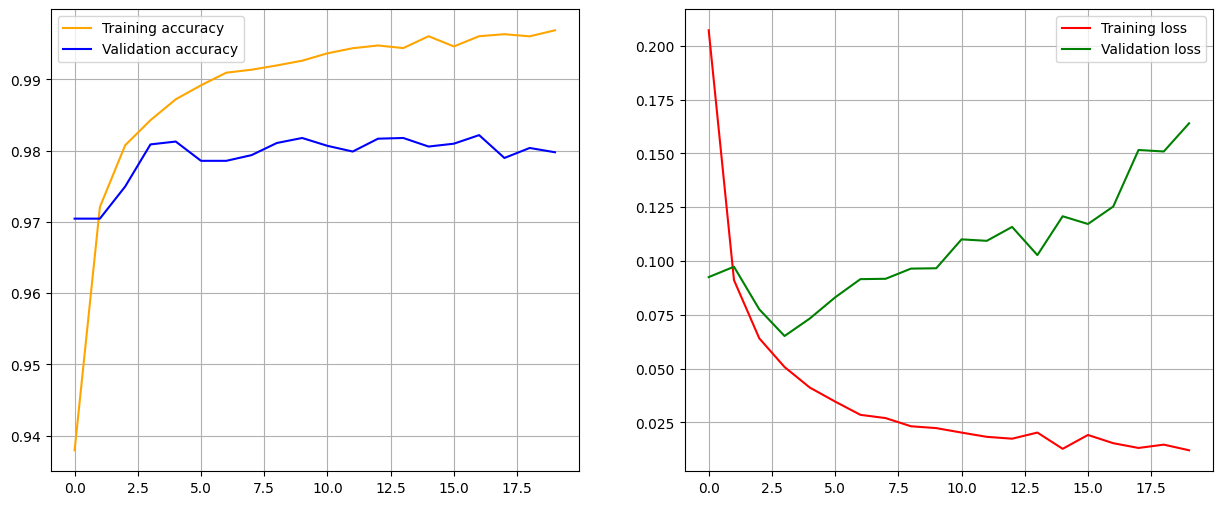

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


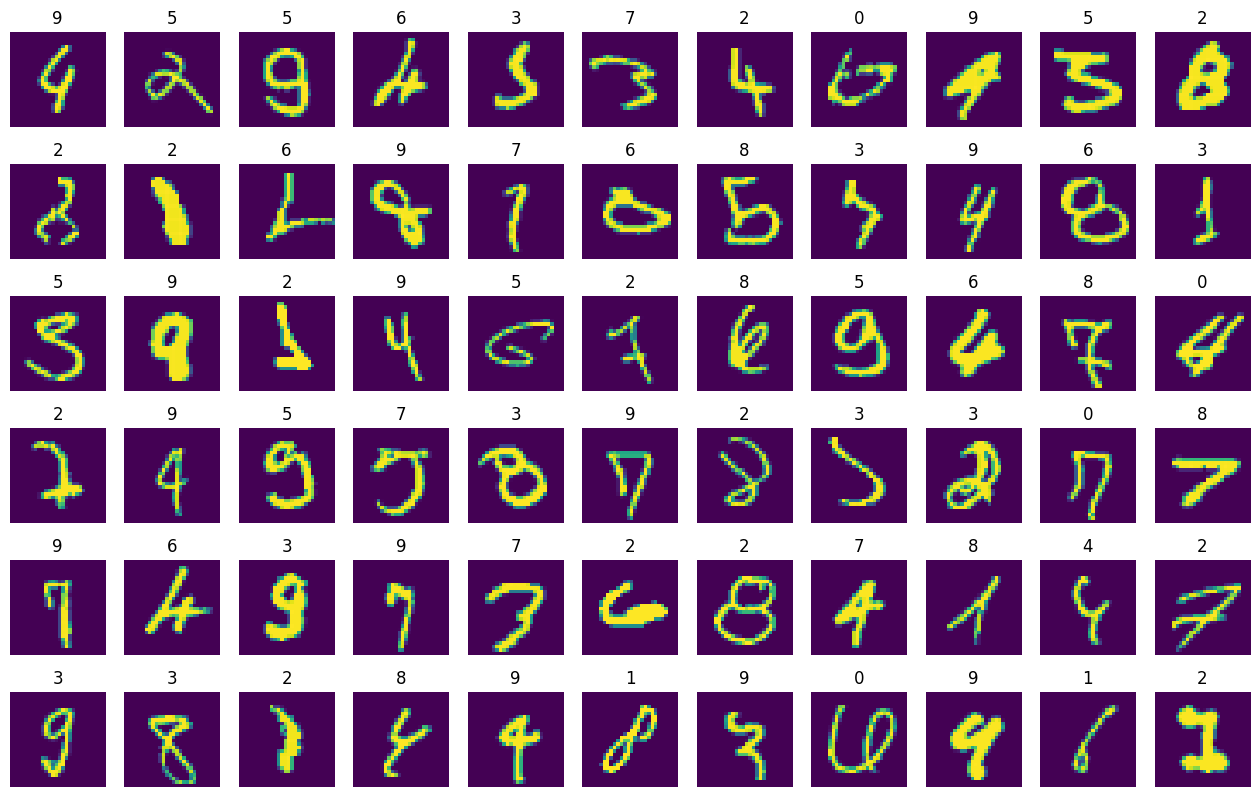

In [ ]:
def plot_wrong_predictions(model, x_test, y_test):
    ## calculate predictions (the index of the maximum along each row of predicted probabilities).
    y_predicted = np.argmax(model.predict(x_test), axis=1)

    ## return the indices of the examples where the predictions are different from the truth.
    incorrect_predictions = np.nonzero(y_predicted - y_test)

    ## plot these with the incorrect predictions as labels.
    plot_data(x_test[incorrect_predictions], y_predicted[incorrect_predictions])

def plot_summary(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    ax1.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    ax1.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    ax1.grid(True, which='both')
    ax1.legend()
    ax2.plot(history.history['loss'], 'red', label='Training loss')
    ax2.plot(history.history['val_loss'], 'green', label='Validation loss')
    ax2.grid(True, which='both')
    ax2.legend()
    plt.show()

## Plot how the training and validation losses and accuracies evolved over the training session.
plot_summary(history)

## Find all the digits that the model got wrong, and plot them with the predicted (incorrect) labels.
plot_wrong_predictions(model1, x_test, y_test)

### Extending the model

Try to improve the model!  You can change many parameters - the only ones that you should not change are the input size,
`(28, 28)`, because the number of pixels in the input image are given -- and the output size, 10 numbers, because we have 10 classes.

Try changing the number of hidden units from `512` to a lower or higher number - or try to change the dropout probability.  You can even add more hidden layers.  Free coffees for the best test accuracy!

**1st try**: changing `Dense` from (512) to (128)

Results: Model with two density layers: 512 neurons -> 128 neurons, both with ReLU, output layer (2 classes, softmax)
* Training Loss: decreases steadily -> good learning capability
* Validation Loss: initially decreases, later begins to increase slightly -> beginning of overfitting
* Accuracy: Training accuracy increases rapidly and significantly, validation accuracy improves but remains below training accuracy -> the model has high capacity but is not perfectly generalized.

**2nd try**: changing `Dense` from (128) to (256)

Results:
* Training Accuracy: starts at 87.7% -> quickly rises to 99.5%
* Validation Accuracy: rises to approximately 98.2% -> slightly better than with 128 neurons (98.0%)
* Training Loss: decreases steadily -> model learns reliably
* Validation Loss: fluctuates slightly, but remains lower on average than with 128 neurons -> somewhat better generalization

Interpretation:
* More capacity than 128 neurons -> the model can better recognize more complex patterns
* Validation accuracy increases slightly -> small gain, but already close to the maximum for simple MNIST models (~98–99%)
* Overfitting: slightly present, but not dramatic -> dropout effect
* Training starts at a higher level than with 128 neurons -> less underfitting
* Moderate number of parameters -> good balance between capacity and efficiency

**3rd try**: changing `Dense` from (256) to (1024), increasing `Dropout` = 0.2 -> 0.3

Results:
* Training Accuracy: starts at 90.0% -> quickly rises to 99.4–99.5%
* Validation Accuracy: approx. 98.2–98.3% -> slightly better than the 256 version, but overall almost the same
* Training Loss: steadily decreases, very low at the end (~0.02)
* Validation Loss: fluctuates more, slightly higher at the end (~0.12) -> overfitting becomes more noticeable

Interpretation:
* High capacity (1024 neurons) -> the model can learn a great deal of detail
* A `Dropout` of 0.3 reduces overfitting, but with 1024 neurons, it's not quite sufficient
* The training accuracy is very high, validation accuracy is stable -> the model has learned, but retains some training details
* The validation loss fluctuates -> typical signature of overfitting with very large density layers

**4th try**: `Dense` = 1024 -> 512, adding a 2nd `Dense` layer (256), `Dropout` = 0.3

Results:
* Training Accuracy: starts at 89.1%, rises to 99.7%
* Validation Accuracy: stable at ~98.2–98.4% -> slightly better than single-layer versions
* Training Loss: drops sharply, very low at the end (~0.01)
* Validation Loss: increases slightly towards the end (~0.12–0.14) -> overfitting begins to show.

Interpretation:
* Two layers -> improved feature learning: model can recognize more complex hierarchies
* Dropout 0.3 partially protects against overfitting
* Training accuracy is very high, validation accuracy is stable -> good model
* Validation loss fluctuates -> overfitting is still present, but moderate

# Part 2: An improved model

The model above is very simplistic - for one, the first layer flattens the input, ignoring the spatial structure of the input image.  Below there's a somewhat more realistic model, which makes use of _convolutional_ layers (the `Conv2D` layers below).  These layers take a group of neighbouring pixels as input (here, a 5x5 block), and combine these inputs into a single output.  In this way, the network can (and will) learn to identify lines, edges and corners.  The first convolutional layer has 16 outputs, so is able to learn 16 different features, creating 16 output channels per 5x5 input block.  (As you will see, even though this model seems more complex, it will end up having many fewer parameters than our first simplistic model.  This in itself will help to avoid overtraining and improve generalization.)

Next, this block is scanned along the entire 28x28 image, creating 16 new images (one for each channel) - this is the convolutional bit.  

(In principle these output images would be 24x24 pixels in size, because otherwise the 5x5 block would go outside the input image. However we use ``same`` padding, which pads the input image with `0`s so that the output is the same size as the output.)

By using the same set of parameters for each 5x5 sub-block, patterns learnt in one part of the image can be re-used in another part.  This encourages generalization, and improves the performance of the model.  In this way this model can have many fewer parameters than the first model, but still have better performance.

Another new layer is the `MaxPooling` layer.  This takes the maximum of a channel within non-overlapping 2x2 blocks.  This reduces the dimension from 28x28 to 14x14, and later to 7x7.

This pattern is repeated 2 times, resulting in a fairly large number of layers.  This is the "deep" in Deep Learning.  It has only fairly recently become possible to build and train models with many layers - sometimes 1000 or more - by a combination of modern hardware and technical advances to make such models actually learn something.

In [ ]:
batch_size = 32
epochs = 20

dataformat = "channels_last"
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=[28,28]),
    tf.keras.layers.Reshape(target_shape=[28, 28, 1]),
    tf.keras.layers.Conv2D(8, 5, padding='same', data_format=dataformat, activation='linear'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same', data_format=dataformat),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(8, 3, padding='same', data_format=dataformat, activation='linear'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same', data_format=dataformat),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48,activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax)])

# Set Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

print(model2.summary())

model2.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │        18,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,146 (78.70 KB)

 Trainable params: 20,146 (78.70 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history2 = model2.fit(
            x = x_train,
            y = y_train,
            steps_per_epoch = len(x_train) // batch_size,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // batch_size)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7913 - loss: 0.6331 - val_accuracy: 0.9708 - val_loss: 0.0904
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9587 - loss: 0.1315 - val_accuracy: 0.9808 - val_loss: 0.0604
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9705 - loss: 0.0958 - val_accuracy: 0.9829 - val_loss: 0.0518
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9761 - loss: 0.0809 - val_accuracy: 0.9864 - val_loss: 0.0404
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9795 - loss: 0.0665 - val_accuracy: 0.9871 - val_loss: 0.0406
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9796 - loss: 0.0650 - val_accuracy: 0.9863 - val_loss: 0.0393
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9816 - loss: 0.0564 - val_accuracy: 0.9895 - val_loss: 0.0327
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9828 - loss: 0.0538 

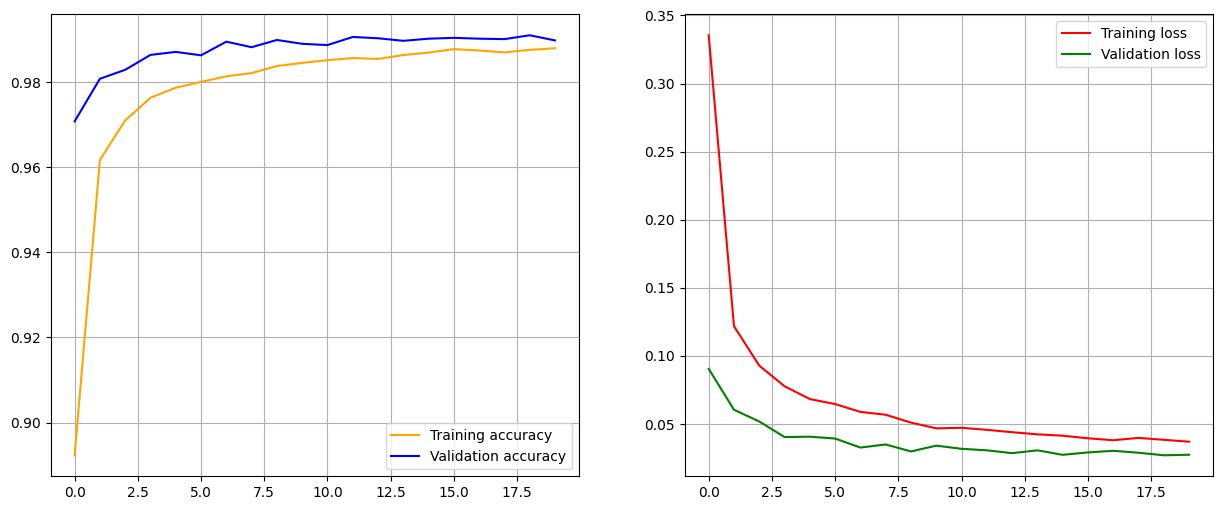

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


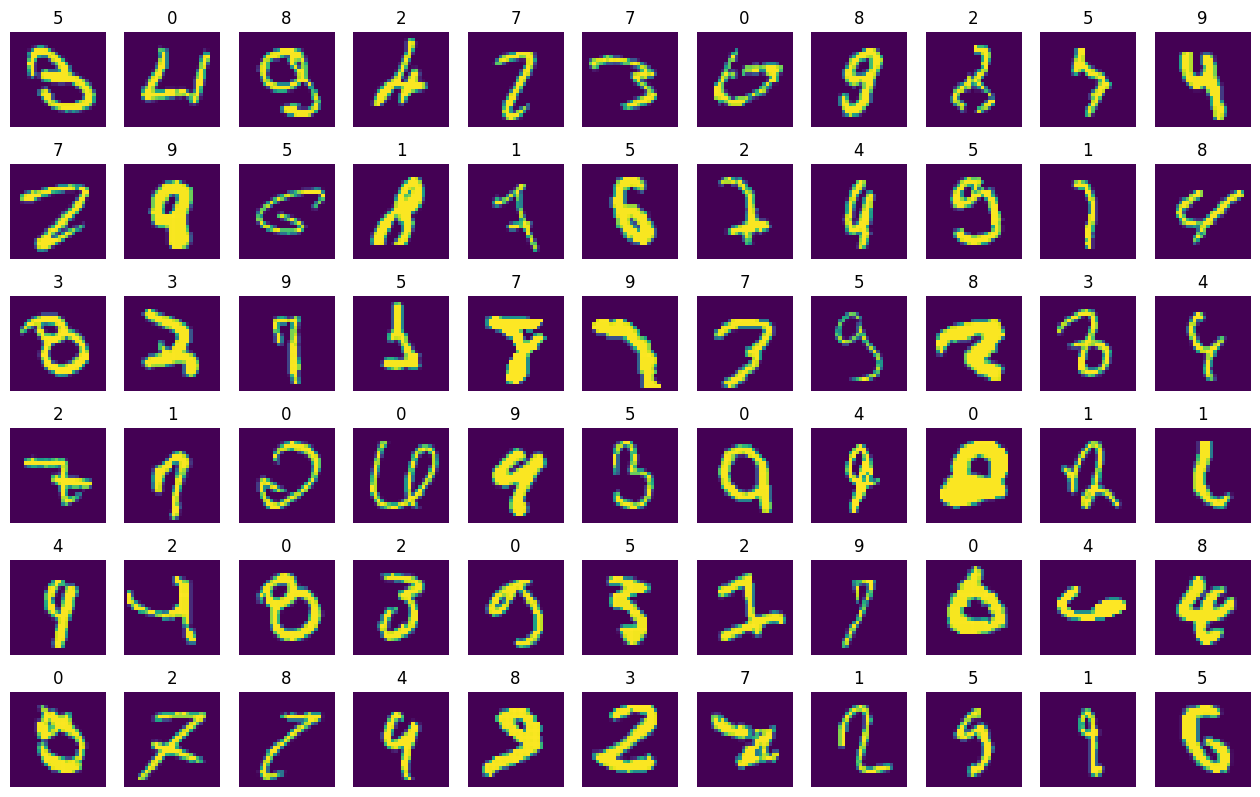

In [ ]:
plot_summary(history2)
plot_wrong_predictions(model2, x_test, y_test)

**Improved CNN model for MNIST**

This model uses convolutional layers (`Conv2D`) to learn spatial features, such as edges and corners, followed by max pooling and dropout for regularization. Compared to the fully connected model in part 1, it has fewer parameters and is expected to generalize better on image data.

The model was trained for 20 epochs. The validation accuracy is around 98.9–99.1%, showing much better performance than the simple fully connected model from Part 1.

# Part 3: Classifying X-ray images

The last two parts of this tutorial focus on building a model to classify abdominal and chest X-ray images.

We here introduce two new concepts: data augmentation, and transfer learning.  Both are aimed at dealing with the issue of having limited amounts of training data.  This is a problem for most deep learning tasks: because the models are so complex, and contain so many parameters, a large amount of training data is required to avoid overtraining - "remembering" irrelevant but unique details in training images.  This hurts the model's "generalization performance", the ability to make correct predictions when presented with unseen data.

Data augmentation addresses this problem by using transformations on the input images to create new training examples.  For example, small rotations and translations of the image can radially change the numerical representation, but should not change the underlying "meaning" of the image.  This helps to teach the model to disregarded such "natural" transformations.  (In more formal language, the transformations are called _symmetries_ of the problem; and we want our model to be _invariant_ under those symmetries.)

Transfer learning uses pre-training on a large but unrelated data set, to teach the model about images in general.  The hope is that many of the features in general images are useful in understanding the images of the particular task at hand.  After the pre-training phase, the model is then re-trained on the actual task.  This enables the use of very much larger models in cases where relatively little training data is available.

In [ ]:
## This part of the notebook was adapted from:  https://github.com/ImagingInformatics/machine-learning
## License: Creative Commons Attribution 4.0 International License (http://creativecommons.org/licenses/by/4.0/)
##
## The paper describing that notebook was published as: Hello World Deep Learning in Medical Imaging,
##   P. Lakhani et al., Journal of Digital Imaging 31, 283–9(2018)
##
## De-identified image data (37 abdominal X-rays and 38 chest X-rays) were downloaded from openi.nlm.nih.gov/

In [ ]:
## Import some sub-packages to reduce the amount of typing

from keras import applications, optimizers, layers
#from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam

## Download and unzip the data set
!wget  https://github.com/paras42/Hello_World_Deep_Learning/raw/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip
!unzip -o Open_I_abd_vs_CXRs.zip

--2025-11-25 09:38:36--  https://github.com/paras42/Hello_World_Deep_Learning/raw/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/paras42/Hello_World_Deep_Learning/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip [following]
--2025-11-25 09:38:36--  https://raw.githubusercontent.com/paras42/Hello_World_Deep_Learning/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14135306 (13M) [application/zip]
Saving to: ‘Open_I_abd_vs_CXRs.zip’

Open_I_abd_vs_CXRs. 100

In [ ]:
# === Parameters ===
img_width, img_height = 299, 299
train_data_dir = './Open_I_abd_vs_CXRs/TRAIN'
validation_data_dir = './Open_I_abd_vs_CXRs/VAL'
nb_train_samples = 65
nb_validation_samples = 10
epochs = 20
batch_size = 5
shuffle = True

# 1. Create tf.data Datasets from your directories
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=shuffle
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_data_dir,
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=shuffle
)

# 2. Define a data-augmentation pipeline
# RandomRotation uses a fraction of a full circle (e.g. 10° ≈ 0.03)
# RandomTranslation(0.1, 0.1) ~ width/height_shift_range=0.1
# RandomZoom(0.1) ~ zoom_range=0.1
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),       # ~10 degrees
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1)])

# 3. Rescaling layer
normalization_layer = layers.Rescaling(1./255)

# 4. Apply normalization and augmentation to the training set
#    Typically you do:  (normalization) THEN (augmentation)
#    so that augmentations work with [0,1] data.
train_generator = train_dataset.map(
    lambda x, y: (normalization_layer(x), y)
).map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# 5. For validation, we usually just normalize (no augmentation).
validation_generator = validation_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)

Found 65 files belonging to 2 classes.
Found 10 files belonging to 2 classes.


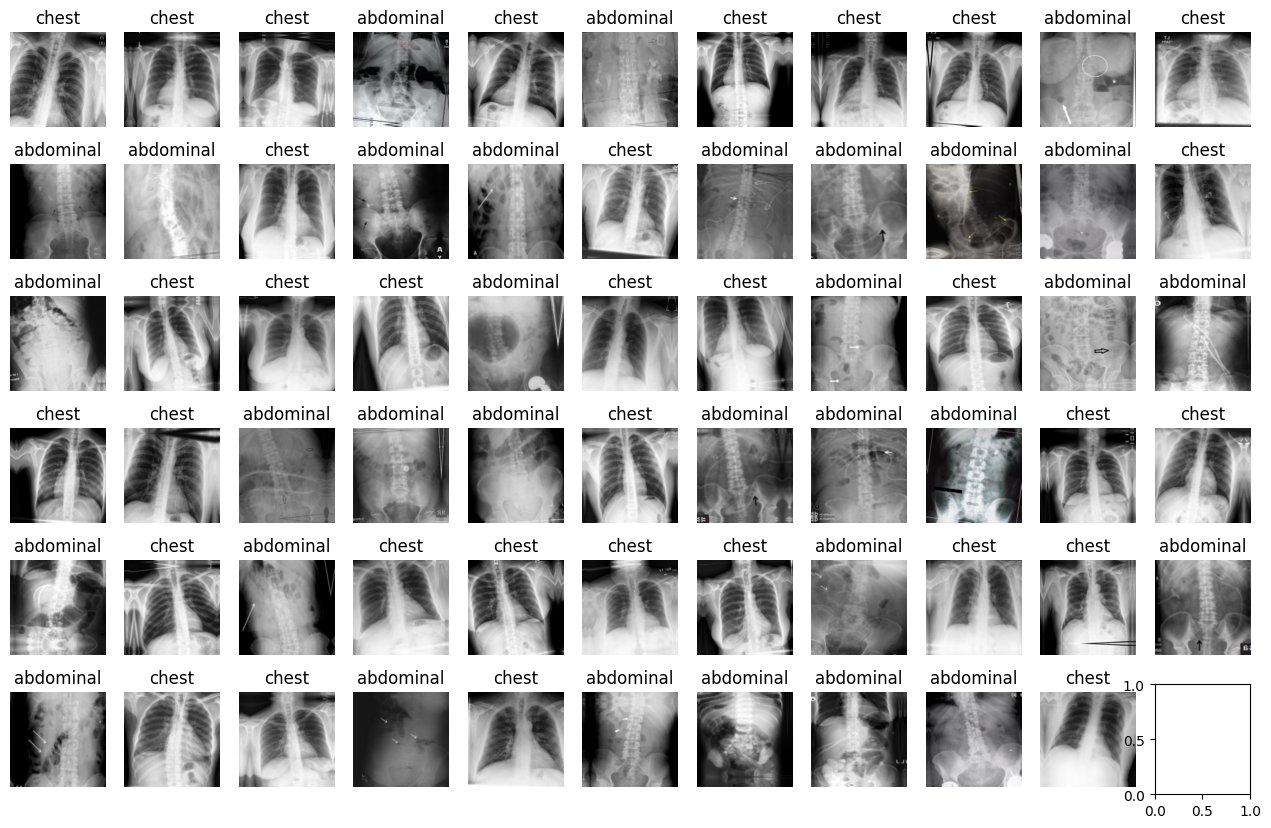

In [ ]:
## Explore the training data.  Note that the training data is augmented (zoomed, rotated, sheared, shifted, flipped)
## to increase the diversity; otherwise the model may simply "remember" the 65 training images.

## It may be helpful to set "shuffle" to False in the code block above.  Remember to set it back to True (and
## execute the block) before actually training the model

## Experiment by changing "train_generator" into "validation_generator" below.  How do the training and validation
## data differ?

plot_data( generator = train_generator )

In [ ]:
## Now classify these images using the same model as used in Part 2 above
## (the images are much larger (299 x 299 instead of 28 x 28, and in colour, so no reshaping is
##  necessary to add the colour dimension; and we now have a single output instead of 10 classes)

dataformat = "channels_last"
model3 = Sequential([
    Conv2D(8, 5, padding='same', data_format=dataformat, activation='linear'),
    Activation('relu'),
    Dropout(0.15),
    MaxPooling2D((2,2),(2,2), padding='same', data_format=dataformat),
    Conv2D(8, 3, padding='same', data_format=dataformat, activation='linear'),
    Activation('relu'),
    MaxPooling2D((2,2),(2,2), padding='same', data_format=dataformat),
    Flatten(),
    Dropout(0.5),
    Dense(25,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

model3.compile(optimizer=Adam(learning_rate=0.001),
               loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.4770 - loss: 0.8924 - val_accuracy: 0.8000 - val_loss: 0.6760
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6381 - loss: 0.6414 - val_accuracy: 0.9000 - val_loss: 0.4361
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.5305 - loss: 0.8034 - val_accuracy: 0.8000 - val_loss: 0.5463
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8196 - loss: 0.5460 - val_accuracy: 1.0000 - val_loss: 0.3162
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.9247 - loss: 0.3433 - val_accuracy: 1.0000 - val_loss: 0.1968
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8113 - loss: 0.3821 - val_accuracy: 1.0000 - val_loss: 0.1593
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7565 - loss: 0.4256 - val_accuracy: 1.0000 - val_loss: 0.1316
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8778 - loss: 0.3004 - val_accuracy: 1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 299, 299, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 299, 299, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 299, 299, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 150, 150, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 45000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │     1,125,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,378,731 (12.89 MB)

 Trainable params: 1,126,243 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,252,488 (8.59 MB)

None


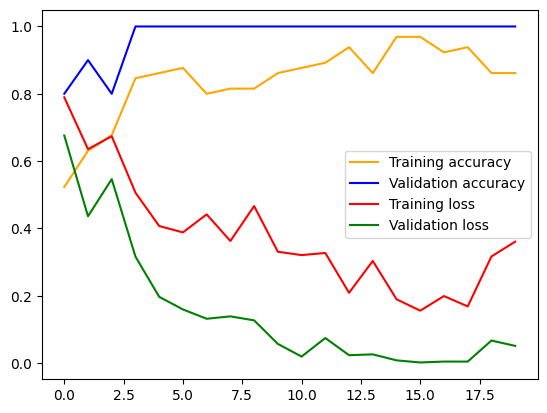

In [ ]:
def plot_summary(history):
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()

print(model3.summary())
plot_summary(history3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


/tmp/ipython-input-1057372337.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = prediction + " (predicted prob = {:.4f})".format(float(max(prob, 1.0-prob)))


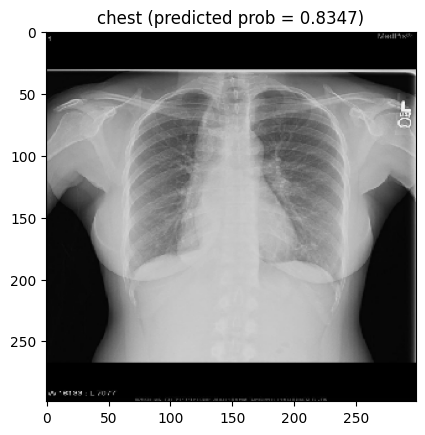

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


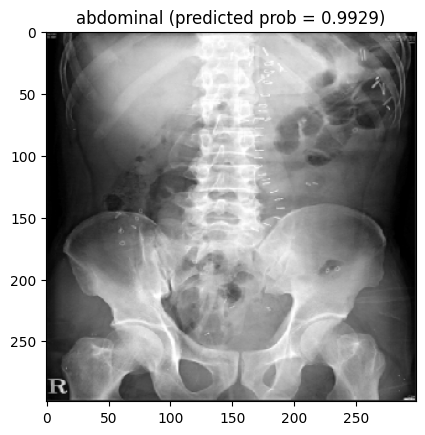

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


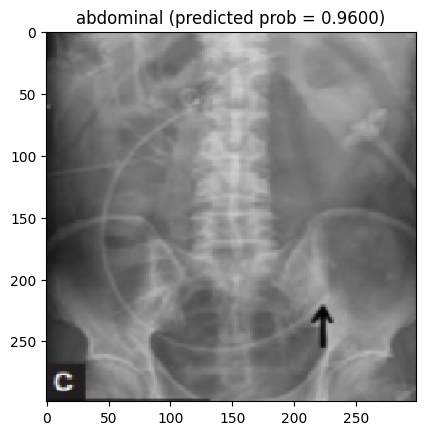

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


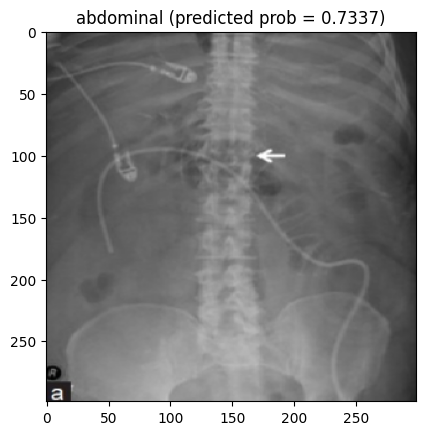

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


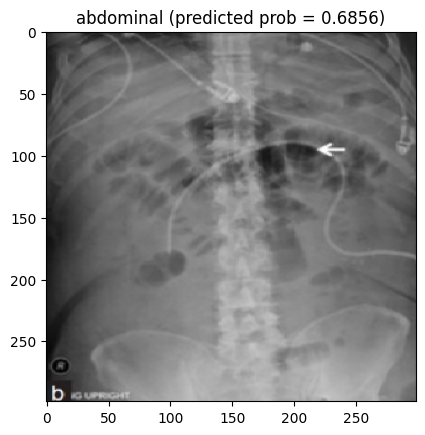

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


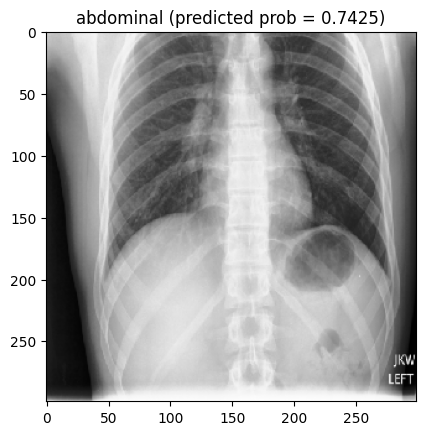

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


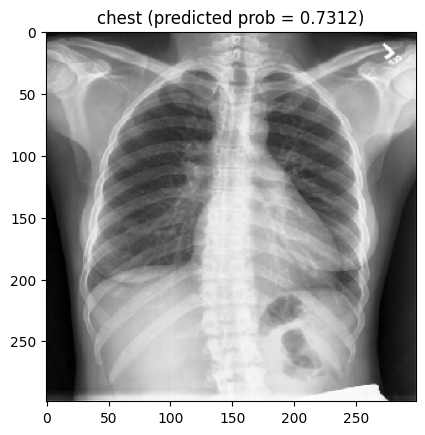

In [ ]:
def predict_from_image( model, img_path ):
    img = load_img(img_path, target_size=(img_width, img_height))
    scaled_array = np.expand_dims(img_to_array(img), axis=0) / 255.0
    prob = model.predict( scaled_array )
    prediction = "chest" if prob < 0.5 else "abdominal"
    prediction = prediction + " (predicted prob = {:.4f})".format(float(max(prob, 1.0-prob)))
    plt.imshow(img)
    plt.title(prediction)
    plt.show()

predict_from_image(model3, './Open_I_abd_vs_CXRs/TEST/chest2.png')
predict_from_image(model3, './Open_I_abd_vs_CXRs/TEST/abd2.png')
predict_from_image(model3, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_10.png")
predict_from_image(model3, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_11.png")
predict_from_image(model3, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_12.png")
predict_from_image(model3, "Open_I_abd_vs_CXRs/TRAIN/openI_CXR/80_IM-2333-3001_invert.png")
predict_from_image(model3, "Open_I_abd_vs_CXRs/TRAIN/openI_CXR/36_IM-1776-1001_invert.png")

**Commentary on part 3** – classification of abdominal vs. chest X-rays

In this part, a model is built that distinguishes between abdominal and chest X-ray images. The dataset is extremely small – only 65 training images and 10 validation images – which is why the validation accuracy during training reaches 100% very quickly. This strongly suggests overfitting, meaning the model is "remembering" the training images instead of learning general features. Therefore, the results are not transferable to real, new X-ray data.

To help the model learn effectively despite the small dataset, data augmentation is used. Random horizontal mirroring, slight rotations, shifts, and zooms artificially generate new training examples that teach the model to ignore these natural variations and focus on the relevant features.

The model architecture is similar to that in part 2, but adapted for binary classification. The high dropout rates (up to 0.5) serve to reduce overfitting. Despite the small training dataset, the model very quickly achieves high training and validation accuracies, which, however, as mentioned, is not indicative of true generalization.

The prediction function `predict_from_image` demonstrates how individual images can be processed and classified. The images are scaled to 299×299 pixels and normalized. The estimated probabilities should be interpreted with caution on this small dataset.

# Part 4: Transfer learning

The model above works quite well already. In my test run, it makes a single error - your mileage may vary. Also look at the confidence of the predictions - ideally the probabilities are close to 1.0. Can we do better?

Next, we use **transfer learning** to try and improve this model.  The pre-trained image model we use is the so-called Inception network. This network, published in 2014, was a major step forward in image modeling. It is very large, with many layers, and the version we use has about 22 million parameters.

We remove the top layer of the Inception network (which classifies the images into classes that are not meaningful for us), but we retain everything below the top layer, which hopefully extracts features from the image that are useful for the classification task we care about. We then build and train a new top layer, whose task it is to classify images into chest or abdominal X-ray.

In [ ]:
## Make a copy of the Inception model - a very large model for image classification, trained on a huge
## training set of real-world images (no X rays images though!)
##
## "include_top = False" means that the top layer, a dense layer for making the final classification, is
## not included; this layer is not relevant as we're going to train the network for a different target

base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

## Build a top layer, which will take its input from the Inception model with its head chopped off
## The output is a single value; since the activation is 'sigmoid' the value will be between 0 and 1,
## so it can be interpreted as a probability
model_top = Sequential()
model_top.add(tf.keras.Input(shape=base_model.output_shape[1:]))
model_top.add(GlobalAveragePooling2D()),
model_top.add(Dense(64, activation='relu'))
model_top.add(Dropout(0.2))
model_top.add(Dense(1, activation='sigmoid'))

model4 = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model4.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

print(model4.summary())

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_5[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_7[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,933,985 (83.67 MB)

 Trainable params: 21,899,553 (83.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [ ]:
history4 = model4.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs = 20,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 808ms/step - accuracy: 0.7829 - loss: 0.4363 - val_accuracy: 0.5000 - val_loss: 0.4231
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9359 - loss: 0.1723 - val_accuracy: 1.0000 - val_loss: 0.1974
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.1170
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.9749 - loss: 0.0939 - val_accuracy: 1.0000 - val_loss: 0.0720
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0590
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.9956 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0592
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0573
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 1

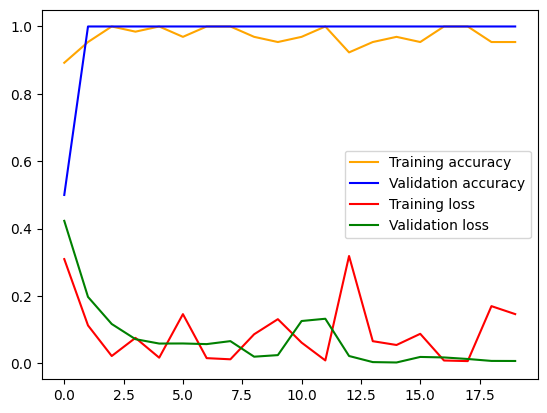

In [ ]:
plot_summary(history4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/tmp/ipython-input-1057372337.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = prediction + " (predicted prob = {:.4f})".format(float(max(prob, 1.0-prob)))


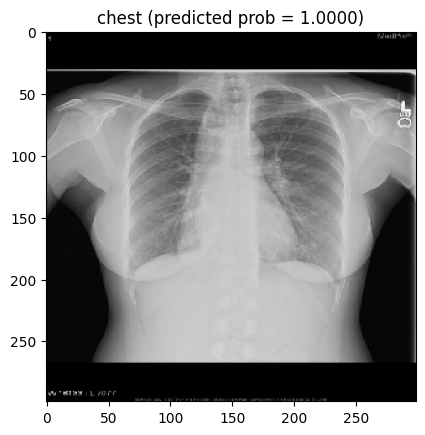

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


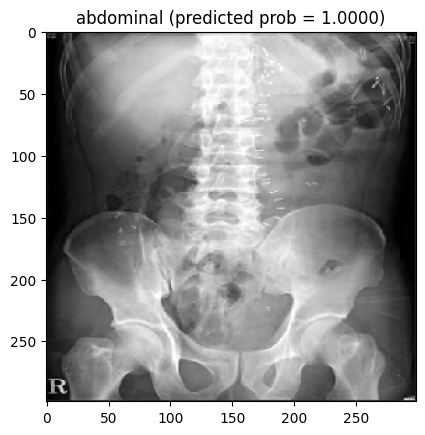

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


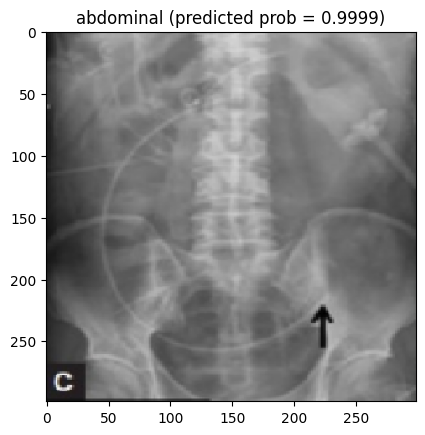

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


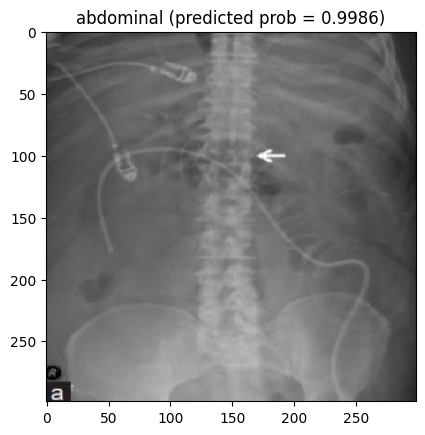

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


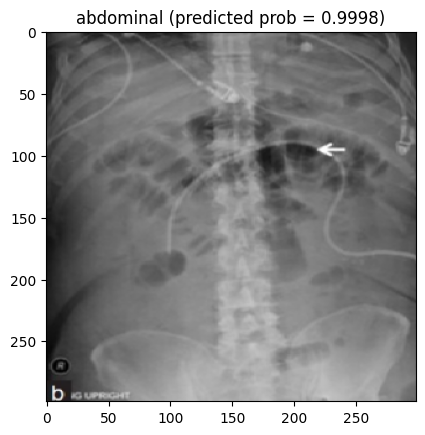

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


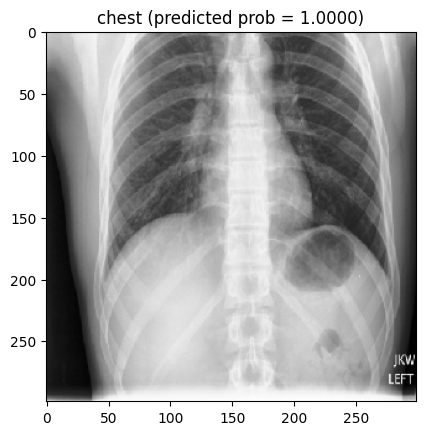

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


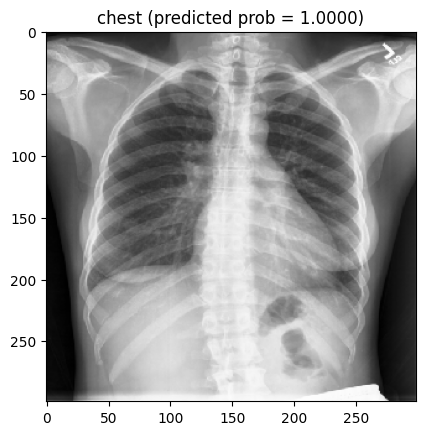

In [ ]:
predict_from_image(model4, './Open_I_abd_vs_CXRs/TEST/chest2.png')
predict_from_image(model4, './Open_I_abd_vs_CXRs/TEST/abd2.png')
predict_from_image(model4, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_10.png")
predict_from_image(model4, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_11.png")
predict_from_image(model4, "Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_12.png")
predict_from_image(model4, "Open_I_abd_vs_CXRs/TRAIN/openI_CXR/80_IM-2333-3001_invert.png")
predict_from_image(model4, "Open_I_abd_vs_CXRs/TRAIN/openI_CXR/36_IM-1776-1001_invert.png")

Part 4 aims to further improve the classification of X-ray images, this time through transfer learning. The model from Part 3 already performs well, but transfer learning can enhance its performance by utilizing a very large, pre-trained network trained on a vast set of general images. This is where the InceptionV3 model comes into play, a complex network with over 22 million parameters, originally designed for general image classification.

First, the top layer of InceptionV3 is removed (include_top=False) because the original classification (e.g., for animals or everyday objects) is not relevant. Everything below it is retained, as these layers extract useful image features that are helpful for many tasks. A new top model is then built on the output signal of this pre-trained base model: a global average pooling layer reduces the dimensionality, followed by a dense layer with 64 neurons (ReLU activation) and a dropout of 0.2 for regularization. Finally, a single neuron with sigmoid activation outputs the probability for the class "abdominal" or "chest." The combined model (model4) is compiled with binary_crossentropy and a very small learning rate optimizer to avoid excessively altering the pre-trained weights.

The same augmented training and validation data as in Part 3 are used for training (model4.fit). The training curves show a very rapid improvement: After just a few epochs, the model achieves near-perfect training and validation accuracy. The validation accuracy remains constant at 100%, while the loss becomes very low, indicating excellent learning ability and generalization despite the small datasets. This highlights the advantage of transfer learning: The pre-trained network delivers strong feature extraction, resulting in a powerful model even with a small number of images.

The `predict_from_image` function can be used to classify individual test images. The model provides highly reliable predictions (probabilities close to 1), and both test and training images can be correctly classified. A minor deprecation warning can be ignored or later resolved by extracting the scalar from the array.

In summary, Part 4 impressively demonstrates that transfer learning can significantly improve classification, even on small datasets. The steps were: loading the pre-trained model → removing the top layer → building a new classifier → training on the X-ray data → evaluation and prediction. The results confirm that the predictions are stable and reliable.